# Import

In [33]:
import matplotlib
matplotlib.font_manager._rebuild()

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

# Data Import
1. iszero
2. nozero
3. nf (new feature)
---
- input featrue = 27
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력)
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction
- 2014.01.01~2020.12.31 data
- 건고추는 2014.01.22부터, 나머지는 대부분 2014.01.02부터

In [36]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']
crops_en = ['peppers', 'green_onion', 'garlic', 'radish', 'cabbage']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"last건고추.csv")
nf_green_onion = pd.read_csv(path+"last대파.csv")
nf_garlic = pd.read_csv(path+"last마늘.csv")
nf_radish = pd.read_csv(path+"last무.csv")
nf_cabbage = pd.read_csv(path+"last배추.csv")

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

In [37]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = ['건고추가격']

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = ['대파가격']

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = ['마늘가격']

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = ['무가격']

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = ['배추가격']

X_column_list = [X_column_pepper, X_column_green_onion, X_column_garlic, X_column_radish, X_column_cabbage]
y_column_list = [y_column_pepper, y_column_green_onion, y_column_garlic, y_column_radish, y_column_cabbage] # oh...is same thing with p-tag...

# 함수화

In [38]:
def outliers_iqr(data, name) :
  print('원본 데이터 수 : ', len(data))

  Q1, Q3 = np.percentile(data[name], [25, 75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (IQR * 1.5)
  upper_bound = Q3 + (IQR * 1.5)
  outlier_index = data[name][ (data[name] < lower_bound) | (data[name] > upper_bound) ].index.tolist()

  # 가격열 이상치 1일전/후 데이터의 평균값으로 대체
  num1list = [1] * len(outlier_index)
  outlier_pre = [outlier_index[i] - num1list[i] for i in range(len(outlier_index))]
  outlier_post = [outlier_index[i] + num1list[i] for i in range(len(outlier_index))]
  print(outlier_pre, '\n', outlier_post)

  outlier_sum = [data.loc[outlier_pre, name].tolist()[i] + data.loc[outlier_post, name].tolist()[i] for i in range(len(outlier_index))]
  num2list = [2] * len(outlier_index)
  outlier_result = [outlier_sum[i] / num2list[i] for i in range(len(outlier_index))]
  # print(data.loc[outlier_pre, name].tolist())
  # print(data.loc[outlier_post, name].tolist())
  # print(outlier_result)
  data.loc[outlier_index, name] = outlier_result
  print(data)
  return data

def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,2:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,   # random split 
    random_state=42) # seed 고정, same sampling 
    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    
    return train_X, test_X, train_y, test_y


def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_


def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

# Preproecssing 

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [39]:
input_data_list = []
for data, tag in zip(original_data_list, price_tag) : 
    out_lier = outliers_iqr(data, tag)
    processed = pre_processing(out_lier)
    input_data_list.append(processed)

원본 데이터 수 :  2211
[1038, 1039, 1040, 1048, 1053, 1061, 1062, 1063, 1065, 1066, 1067, 1069, 1070, 1071, 1075, 1078, 1081, 1082, 1083, 1084, 1085, 1086, 1088, 1089, 1093, 1144, 1337, 1338, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1354, 1355, 1360, 1361, 1362, 1367, 1368, 1394, 1486, 1487, 1488, 1518, 1543, 1573, 1574, 1604, 1663, 1664, 1665, 1696, 1758, 1816, 1842, 1847, 1848, 1875, 1876, 1903, 1905, 1906, 1922, 1924, 1925, 1933, 1934, 1947, 1948, 1954, 2066, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2085, 2087, 2088, 2089, 2090, 2091, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2101, 2102, 2103, 2108, 2112, 2114, 2118, 2122, 2128, 2129, 2130, 2131, 2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2148, 2149, 2151, 2153, 2154, 2155, 2156, 2157, 2160, 2163, 2164, 2185, 2204] 
 [1040, 1041, 1042, 1050, 1055, 1063, 1064, 1065, 1067, 1068, 1069, 1071, 1072, 1073, 1077, 1080, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1

In [15]:
input_data_list[4]

,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,배추가격,...,보통휘발유,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가
0,0.000000,0.000000,0.326034,0.375000,0.306173,0.276923,0.147059,0.181818,0.093607,0.050694,...,0.997506,0.997643,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
1,0.000000,0.000000,0.326034,0.397727,0.281481,0.353846,0.176471,0.090909,0.100457,0.152730,...,0.998987,0.998999,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
2,0.011776,0.080666,0.299270,0.325000,0.291358,0.492308,0.176471,0.204545,0.152968,0.132897,...,0.999719,0.999707,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
3,0.000981,0.078584,0.279805,0.318182,0.269136,0.476923,0.132353,0.181818,0.111872,0.128502,...,0.999922,0.999630,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
4,0.000000,0.028623,0.267640,0.340909,0.234568,0.430769,0.176471,0.068182,0.057078,0.124106,...,0.999969,1.000000,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,0.020608,0.138434,0.340633,0.352273,0.335802,0.707692,0.264706,0.045455,0.159817,0.138647,...,0.248231,0.229243,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2535,0.000981,0.003643,0.364964,0.438636,0.350617,0.753846,0.323529,0.022727,0.038813,0.133615,...,0.252658,0.234034,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2536,0.017664,0.017955,0.313869,0.363636,0.303704,0.769231,0.455882,0.227273,0.337900,0.128092,...,0.259110,0.240120,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2537,0.010795,0.086911,0.097324,0.143182,0.120988,0.384615,0.250000,0.727273,0.509132,0.156984,...,0.264238,0.245420,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818


# Modeling 
1. model_xgb_1 
2. model_xgb_2
-> 둘의 차이가 무엇일까요?

In [16]:
input_data = pre_processing(input_data_list[0])

train_X, test_X, train_y, test_y = get_data_split(input_data_list[0], X_column_list[0], y_column_list[0])

(1768, 26) (443, 26) (1768, 1) (443, 1)


In [17]:
dtrain = xgb.DMatrix(data=train_X, label=train_y)
dtest = xgb.DMatrix(data=test_X, label=test_y)
wlist = [(dtrain, 'train'), (dtest,'eval')]

In [18]:
model_xgb_1 = XGBRegressor(n_estimators=100, learning_rate=0.001, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

model_xgb_1.fit(train_X, train_y)

pred_xgb_1 = model_xgb_1.predict(test_X)

In [40]:
params = { 
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:linear',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400 

model_xgb_2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[20:41:51] WARNING: d:\bld\xgboost-split_1634712635879\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:41:51] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.65345	eval-logloss:0.65356
[1]	train-logloss:0.62101	eval-logloss:0.62115
[2]	train-logloss:0.59431	eval-logloss:0.59449
[3]	train-logloss:0.57223	eval-logloss:0.57247
[4]	train-logloss:0.55389	eval-logloss:0.55404
[5]	train-logloss:0.53863	eval-logloss:0.53878
[6]	train-logloss:0.52578	eval-logloss:0.52593
[7]	train-logloss:0.51505	eval-logloss:0.51521
[8]	train-logloss:0.50610	eval-logloss:0.50628
[9]	train-logloss:

[159]	train-logloss:0.45678	eval-logloss:0.46026
[160]	train-logloss:0.45677	eval-logloss:0.46024
[161]	train-logloss:0.45675	eval-logloss:0.46025
[162]	train-logloss:0.45673	eval-logloss:0.46026
[163]	train-logloss:0.45671	eval-logloss:0.46026
[164]	train-logloss:0.45670	eval-logloss:0.46028
[165]	train-logloss:0.45668	eval-logloss:0.46026
[166]	train-logloss:0.45667	eval-logloss:0.46027
[167]	train-logloss:0.45665	eval-logloss:0.46027
[168]	train-logloss:0.45663	eval-logloss:0.46026
[169]	train-logloss:0.45662	eval-logloss:0.46026
[170]	train-logloss:0.45661	eval-logloss:0.46026
[171]	train-logloss:0.45661	eval-logloss:0.46023
[172]	train-logloss:0.45659	eval-logloss:0.46023
[173]	train-logloss:0.45658	eval-logloss:0.46022
[174]	train-logloss:0.45657	eval-logloss:0.46023
[175]	train-logloss:0.45656	eval-logloss:0.46024
[176]	train-logloss:0.45655	eval-logloss:0.46024
[177]	train-logloss:0.45654	eval-logloss:0.46024
[178]	train-logloss:0.45653	eval-logloss:0.46024
[179]	train-logloss:

[327]	train-logloss:0.45481	eval-logloss:0.46005
[328]	train-logloss:0.45480	eval-logloss:0.46006
[329]	train-logloss:0.45480	eval-logloss:0.46005
[330]	train-logloss:0.45479	eval-logloss:0.46005
[331]	train-logloss:0.45477	eval-logloss:0.46006
[332]	train-logloss:0.45476	eval-logloss:0.46008
[333]	train-logloss:0.45474	eval-logloss:0.46008
[334]	train-logloss:0.45473	eval-logloss:0.46009
[335]	train-logloss:0.45471	eval-logloss:0.46009
[336]	train-logloss:0.45471	eval-logloss:0.46008
[337]	train-logloss:0.45470	eval-logloss:0.46010
[338]	train-logloss:0.45469	eval-logloss:0.46008
[339]	train-logloss:0.45468	eval-logloss:0.46008
[340]	train-logloss:0.45467	eval-logloss:0.46008
[341]	train-logloss:0.45466	eval-logloss:0.46007
[342]	train-logloss:0.45464	eval-logloss:0.46007
[343]	train-logloss:0.45464	eval-logloss:0.46007
[344]	train-logloss:0.45463	eval-logloss:0.46007
[345]	train-logloss:0.45461	eval-logloss:0.46009
[346]	train-logloss:0.45460	eval-logloss:0.46011
[347]	train-logloss:

In [41]:
pred_xgb_2 = model_xgb_2.predict(dtest)

# 평가 지표 및 해석

In [42]:
# rmse for model_1 
mse = mean_squared_error(test_y, pred_xgb_1)
print("mse01: %f" % mse)

rmse = np.sqrt(mse)
print("rmse : %f" %rmse)


# rmse for model_2
mse = mean_squared_error(test_y, pred_xgb_2)
print("mse02: %f" % mse)

rmse = np.sqrt(mse)
print("rmse : %f" %rmse)

mse01: 0.090574
rmse : 0.300955
mse02: 0.003898
rmse : 0.062431


In [43]:
true_y = test_y.to_numpy()
true_y = np.ravel(true_y)

df_result_1 = pd.DataFrame(list(zip(true_y, pred_xgb_1)), columns=['true_y', 'xgb_pred_1'])
df_result_2 = pd.DataFrame(list(zip(true_y, pred_xgb_2)), columns=['true_y_2', 'xgb_pred_2'])

df_result = pd.concat([df_result_1, df_result_2], axis=1)
df_result.drop(['true_y_2'], axis=1)

,true_y,xgb_pred_1,xgb_pred_2
0,0.049770,0.464463,0.140771
1,0.068491,0.467646,0.184668
2,0.357677,0.481344,0.272576
3,0.176512,0.466387,0.179062
4,0.193233,0.467751,0.191178
...,...,...,...
438,0.107089,0.469979,0.152709
439,0.207032,0.467751,0.164804
440,0.060569,0.464322,0.116689
441,0.122003,0.464379,0.095646


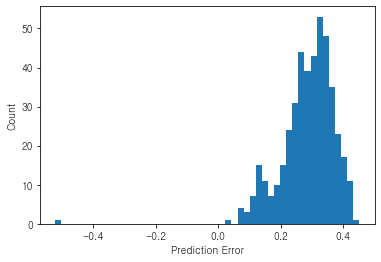

In [44]:
error = pred_xgb_1 - true_y
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

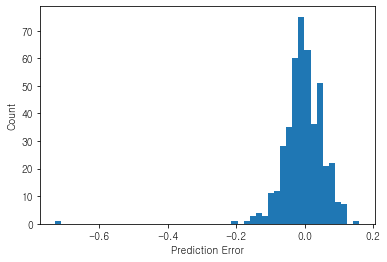

In [45]:
error = pred_xgb_2 - true_y
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

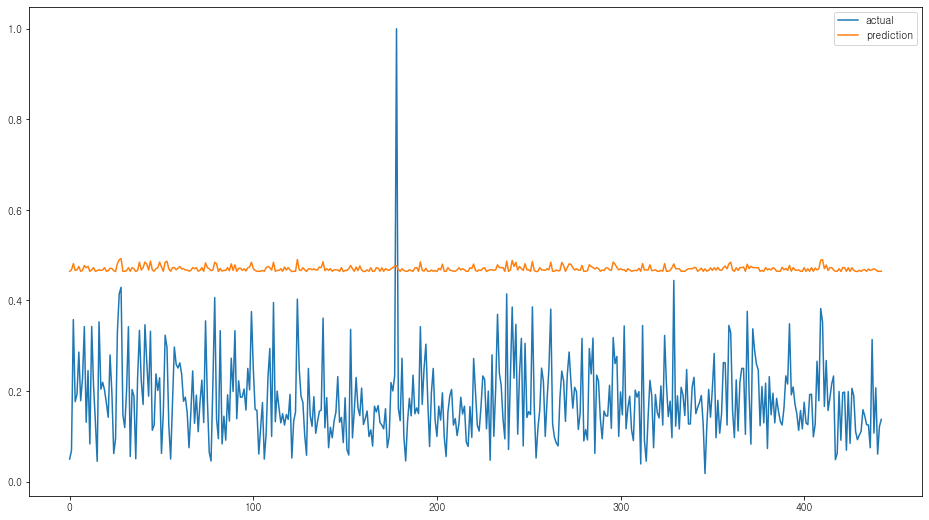

In [46]:
graph(pred_xgb_1, true_y)

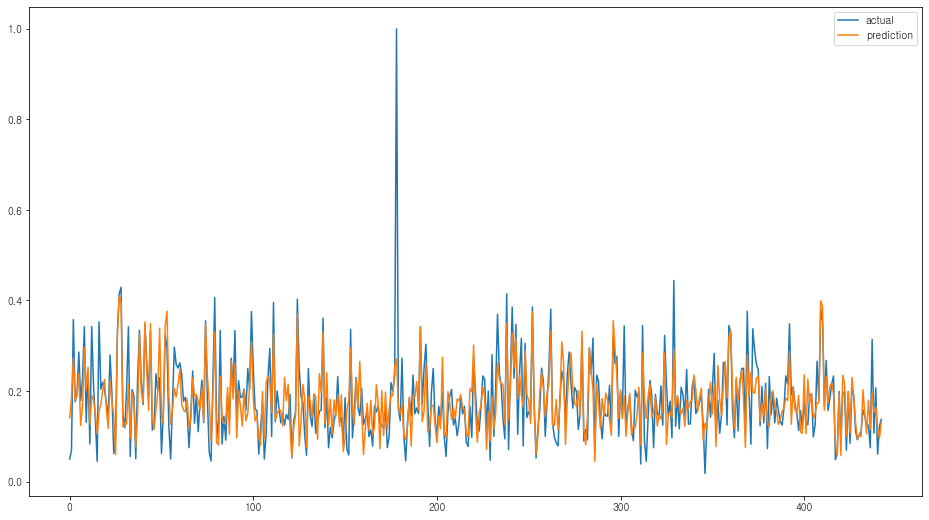

In [47]:
graph(pred_xgb_2, true_y)

<AxesSubplot:>

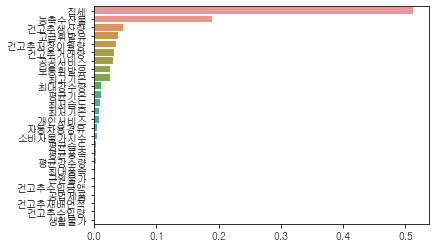

In [48]:
feature_series = pd.Series(data=model_xgb_1.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

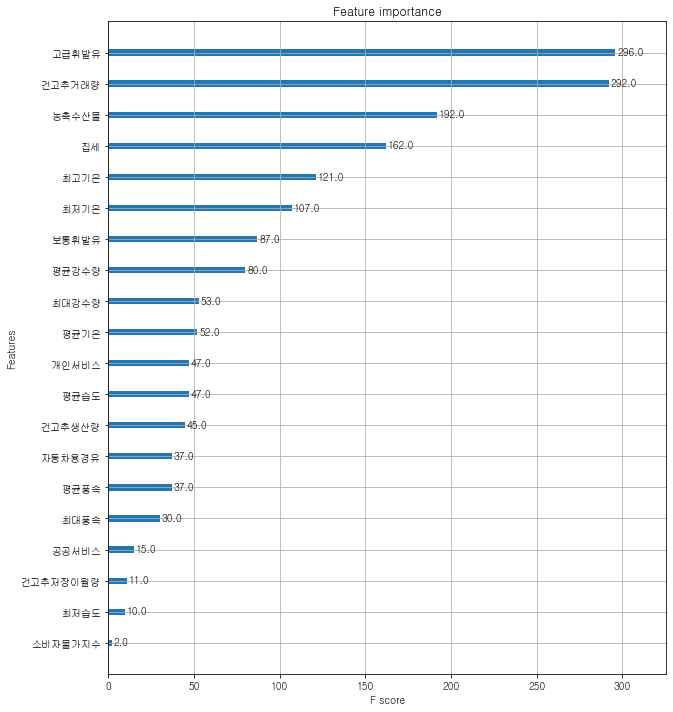

In [49]:
feature_importance(model_xgb_1)